# **Import necessary libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scikit-learn==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 18.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
!pip show joblib

Name: joblib
Version: 1.4.2
Summary: Lightweight pipelining with Python functions
Home-page: 
Author: 
Author-email: Gael Varoquaux <gael.varoquaux@normalesup.org>
License: BSD 3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: imbalanced-learn, librosa, mlxtend, music21, nltk, scikit-learn


In [4]:
import os   # Operating system interactions
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical computing library
import csv   # CSV file handling
from scipy import stats # Statistical functions
import pywt  # Wavelet transform for signal processing
import matplotlib.pyplot as plt  # Data visualization
import seaborn as sns  # Statistical data visualization
from sklearn.model_selection import train_test_split  # Data splitting
from sklearn.decomposition import PCA # Principal Component Analysis (dimensionality reduction)
from sklearn.preprocessing import StandardScaler # Feature scaling
from sklearn.ensemble import RandomForestClassifier # Random Forest classification algorithm
from sklearn.tree import DecisionTreeClassifier # Decision Tree classification algorithm
from sklearn.linear_model import LogisticRegression # Logistic Regression classification algorithm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score , roc_auc_score, roc_curve, auc # Model evaluation metrics
import joblib # For saving and loading trained models
from scipy.signal import welch, find_peaks # Signal processing functions
from scipy.fft import fft # Fast Fourier Transform

# Warning handling
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings (use with caution)

# **Read MITBIH database**

In [5]:
path = '/content/drive/MyDrive/CheckBox/mitbih_database/'
window_size = 190
maximum_counting = 10000

classes = ['N','A','V','F','/']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [6]:
def read_and_separate_files(path):
  """
  Reads files from a directory, separating them by '.csv' and '.txt' extensions.

  Args:
    path: The path to the directory containing the files.

  Returns:
    A tuple containing two lists:
      - A list of paths to '.csv' files.
      - A list of paths to '.txt' files.
  """

  csv_files = []
  txt_files = []

  for filename in sorted(os.listdir(path)):
    file_path = os.path.join(path, filename)

    if filename.endswith('.csv'):
      csv_files.append(file_path)
    elif filename.endswith('.txt'):
      txt_files.append(file_path)

  return csv_files, txt_files

# Example usage:
records, annotations = read_and_separate_files(path)

In [7]:
print("no.of annotation files is : ",len(annotations))
print("no.of records is : " ,len(records))

no.of annotation files is :  48
no.of records is :  48


In [8]:
records

['/content/drive/MyDrive/CheckBox/mitbih_database/100.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/101.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/102.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/103.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/104.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/105.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/106.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/107.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/108.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/109.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/111.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/112.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/113.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/114.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/115.csv',
 '/content/drive/MyDrive/CheckBox/mitbih_database/116.csv',
 '/content/drive/MyDrive/CheckBox/mitbih

In [9]:
annotations

['/content/drive/MyDrive/CheckBox/mitbih_database/100annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/101annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/102annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/103annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/104annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/105annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/106annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/107annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/108annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/109annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/111annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/112annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/113annotations.txt',
 '/content/drive/MyDrive/CheckBox/mitbih_database/114annotations.txt',
 '/con

# **Data Preprocessing and Extraction**

In [10]:
def denoise_fun(data, wavelet='sym4', threshold=0.04):
  """
  Denoises a signal using wavelet thresholding.

  Args:
    data: The input signal as a 1D array-like object.
    wavelet: The name of the wavelet to use. Defaults to 'sym4'.
    threshold: The threshold value for filtering. Defaults to 0.04.

  Returns:
    The denoised signal as a 1D array.
  """

  # Determine the maximum decomposition level
  w = pywt.Wavelet(wavelet)
  maxlev = pywt.dwt_max_level(len(data), w.dec_len)

  # Perform wavelet decomposition
  coeffs = pywt.wavedec(data, wavelet, level=maxlev)

  # Apply thresholding to detail coefficients
  for i in range(1, len(coeffs)):
    coeffs[i] = pywt.threshold(coeffs[i], threshold * max(abs(coeffs[i])), mode='soft')

  # Reconstruct the signal from the modified coefficients
  datarec = pywt.waverec(coeffs, wavelet)

  return datarec

In [11]:
def extract_time_domain_features(beat):
    """Extracts time domain features from a single heartbeat."""

    peaks, _ = find_peaks(beat, prominence=0.2)  # Adjust prominence as needed
    r_peak_index = peaks[0]  # Assuming the first peak is the R-peak
    # Heart Rate Variability (simplified - you'll need RR intervals)
    hrv = np.std(np.diff(peaks)) if len(peaks) > 1 else 0  # Handle cases with one peak

    # QRS Complex Features
    qrs_onset = r_peak_index - window_size // 2  # Assuming QRS starts approx. half window before R-peak
    qrs_end = r_peak_index + window_size // 2    # Assuming QRS ends approx. half window after R-peak
    qrs_duration = qrs_end - qrs_onset
    r_peak_amplitude = beat[r_peak_index]

    # Statistical Features
    mean = np.mean(beat)
    std = np.std(beat)
    skewness = stats.skew(beat)
    kurtosis = stats.kurtosis(beat)

    return [hrv, qrs_duration, r_peak_amplitude, mean, std, skewness, kurtosis]

def extract_frequency_domain_features(beat, sampling_rate=360):
    """Extracts frequency domain features using FFT."""

    # Apply FFT
    yf = fft(beat)
    xf = np.linspace(0.0, sampling_rate / 2, len(beat) // 2)  # Frequency axis
    yf = np.abs(yf[:len(beat) // 2])  # Take the positive frequencies

    # Extract features from the spectrum (examples)
    dominant_frequency = xf[np.argmax(yf)]
    spectral_centroid = np.sum(xf * yf) / np.sum(yf)

    return [dominant_frequency, spectral_centroid]

Streaming output truncated to the last 5000 lines.
Record: 5, Beat Length: 380
Number of Peaks Found: 4
Record: 5, Beat Length: 380
Number of Peaks Found: 4
Record: 5, Beat Length: 380
Number of Peaks Found: 4
Record: 5, Beat Length: 380
Number of Peaks Found: 3
Record: 5, Beat Length: 380
Number of Peaks Found: 3
Record: 5, Beat Length: 380
Number of Peaks Found: 5
Record: 5, Beat Length: 380
Number of Peaks Found: 4
Record: 5, Beat Length: 380
Number of Peaks Found: 3
Record: 5, Beat Length: 380
Number of Peaks Found: 2
Record: 5, Beat Length: 380
Number of Peaks Found: 3
Record: 5, Beat Length: 380
Number of Peaks Found: 3
Record: 5, Beat Length: 380
Number of Peaks Found: 3
Record: 5, Beat Length: 380
Number of Peaks Found: 3
Record: 5, Beat Length: 380
Number of Peaks Found: 5
Record: 5, Beat Length: 380
Number of Peaks Found: 5
Record: 5, Beat Length: 380
Number of Peaks Found: 3
Record: 5, Beat Length: 380
Number of Peaks Found: 4
Record: 5, Beat Length: 380
Number of Peaks Foun

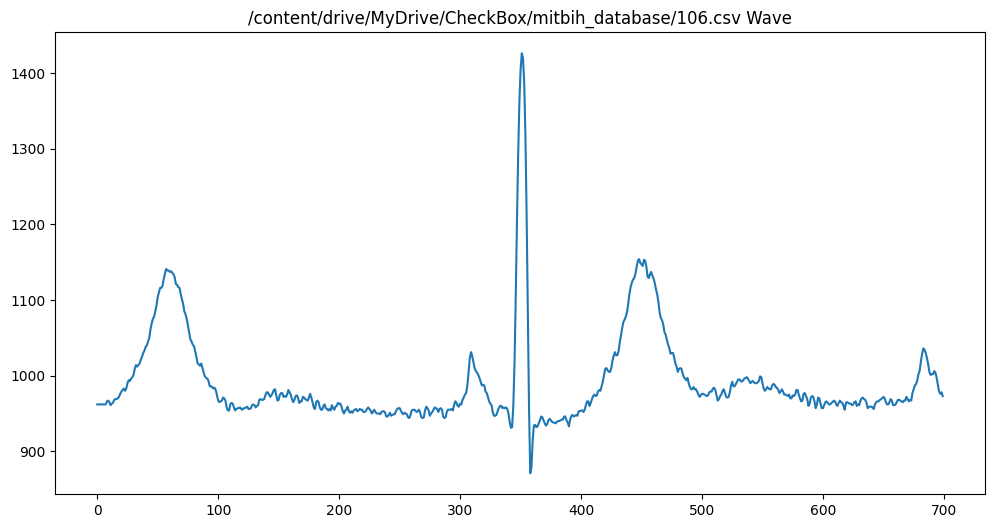

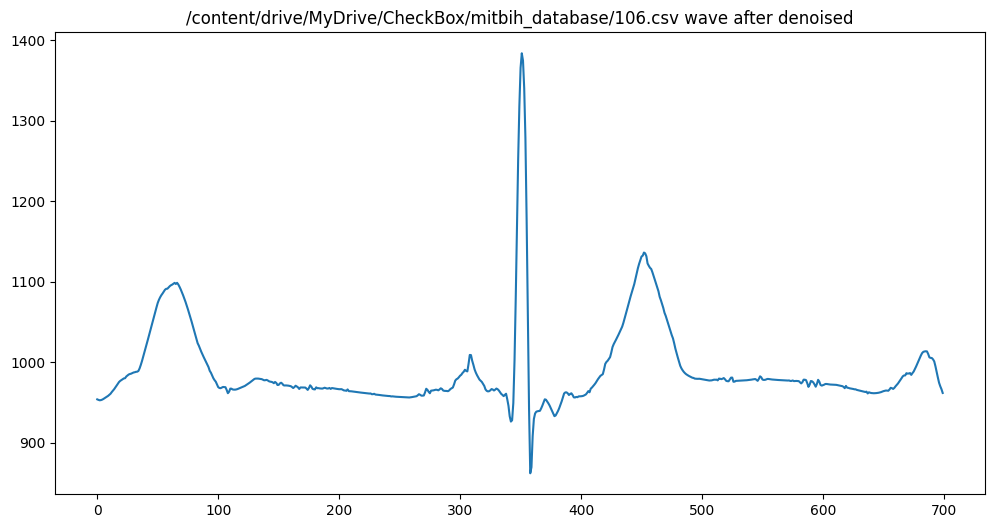

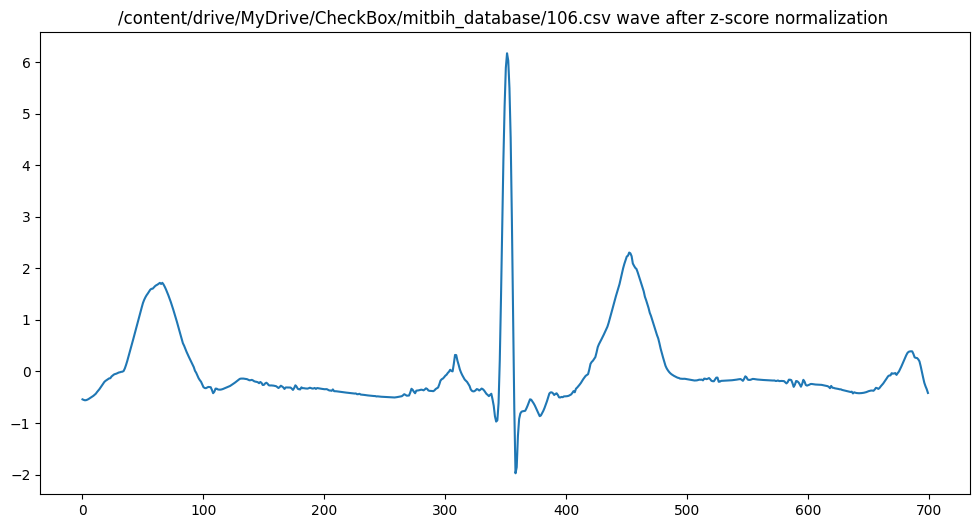

Streaming output truncated to the last 5000 lines.
Record: 7, Beat Length: 380
Number of Peaks Found: 4
Record: 7, Beat Length: 380
Number of Peaks Found: 5
Record: 7, Beat Length: 380
Number of Peaks Found: 2
Record: 7, Beat Length: 380
Number of Peaks Found: 2
Record: 7, Beat Length: 380
Number of Peaks Found: 2
Record: 7, Beat Length: 380
Number of Peaks Found: 3
Record: 7, Beat Length: 380
Number of Peaks Found: 2
Record: 7, Beat Length: 380
Number of Peaks Found: 3
Record: 7, Beat Length: 380
Number of Peaks Found: 4
Record: 7, Beat Length: 380
Number of Peaks Found: 3
Record: 7, Beat Length: 380
Number of Peaks Found: 3
Record: 7, Beat Length: 380
Number of Peaks Found: 2
Record: 7, Beat Length: 380
Number of Peaks Found: 3
Record: 7, Beat Length: 380
Number of Peaks Found: 3
Record: 7, Beat Length: 380
Number of Peaks Found: 3
Record: 7, Beat Length: 380
Number of Peaks Found: 3
Record: 7, Beat Length: 380
Number of Peaks Found: 2
Record: 7, Beat Length: 380
Number of Peaks Foun

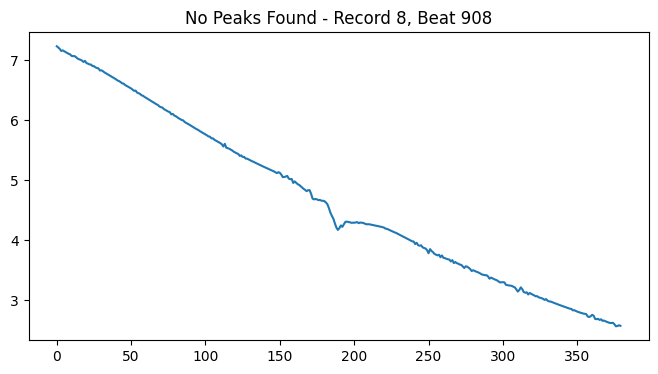

Streaming output truncated to the last 5000 lines.
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 6
Record: 14, Beat Length: 380
Number of Peaks Found: 6
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 6
Record: 14, Beat Length: 380
Number of Peaks Found: 7
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 4
Record: 14, Beat Length: 380
Number of Peaks Found: 6
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 4
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Number of Peaks Found: 5
Record: 14, Beat Length: 380
Nu

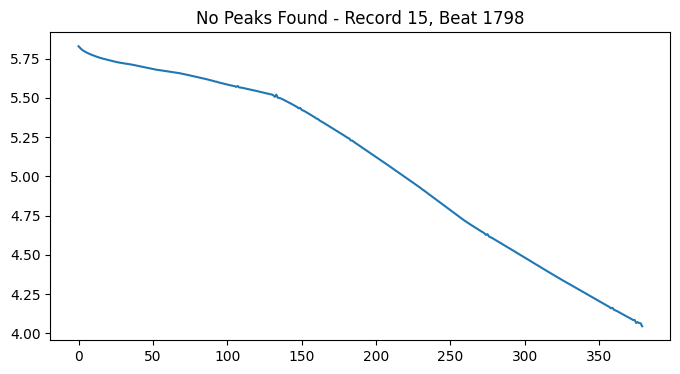

Record: 15, Beat Length: 380
Number of Peaks Found: 0


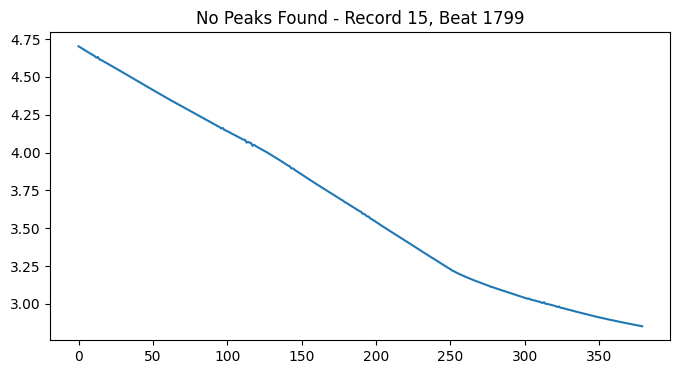

Record: 15, Beat Length: 380
Number of Peaks Found: 0


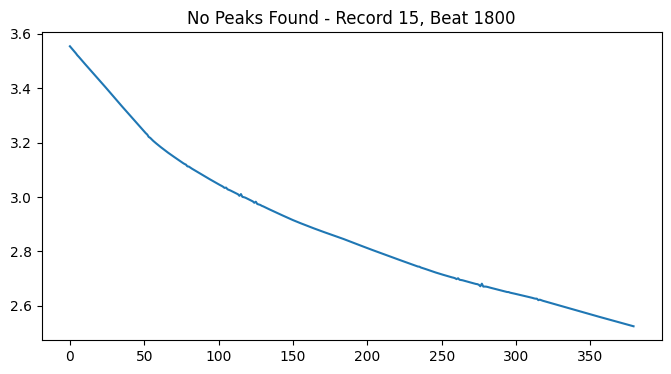

Record: 15, Beat Length: 380
Number of Peaks Found: 0


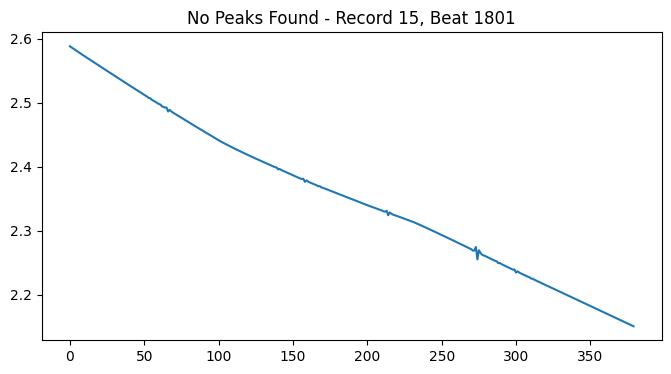

Record: 15, Beat Length: 380
Number of Peaks Found: 0


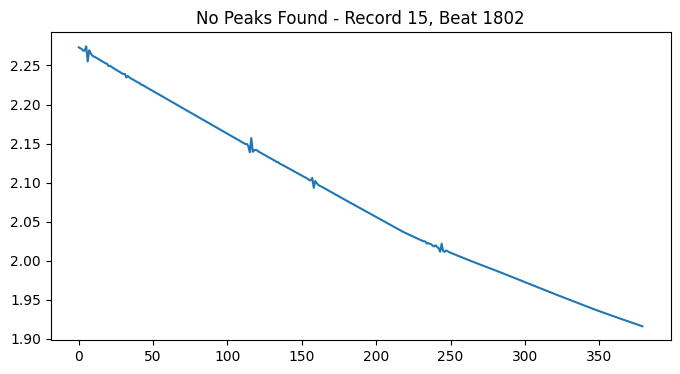

Record: 15, Beat Length: 380
Number of Peaks Found: 0


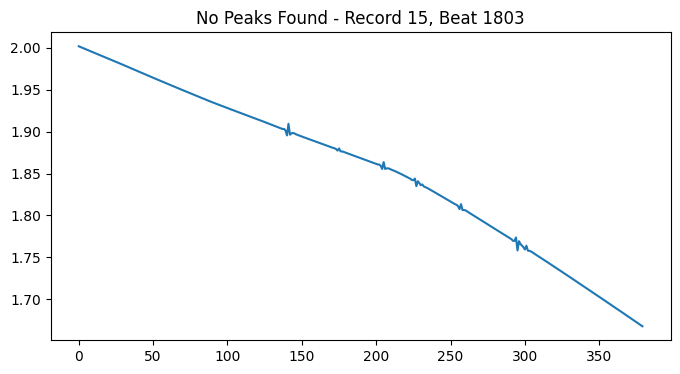

Record: 15, Beat Length: 380
Number of Peaks Found: 0


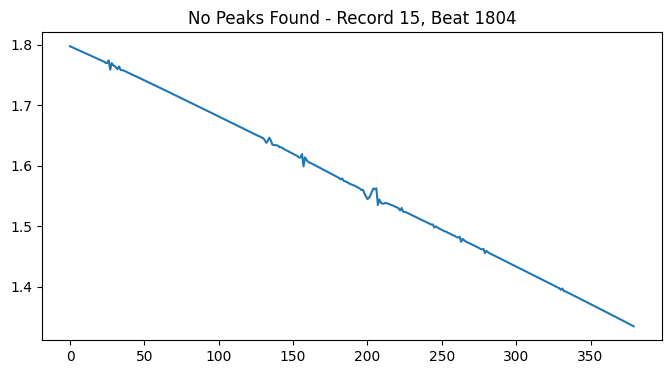

Record: 15, Beat Length: 380
Number of Peaks Found: 0


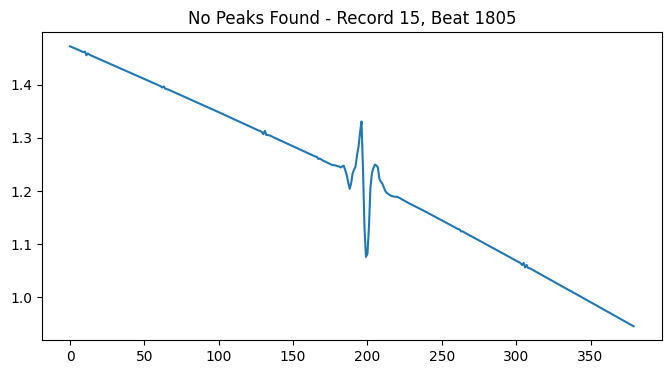

Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 3
Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 1
Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 2
Record: 15, Beat Length: 380
Number of Peaks Found: 3
Record: 15, Beat Length: 380
Number of Peaks Found: 3
Record: 15, Beat Length: 380
Number of Peaks Found: 3
Record: 15, Beat Length: 380
Number of Peaks Found: 1
Record: 15, Beat Length: 380
Number of Peaks Found: 4
Record: 15, Beat Length: 380
Number of Peaks Found: 3
Record: 15, Beat Length: 380
Number of Peaks Found: 3
Record: 15, Beat Length: 380

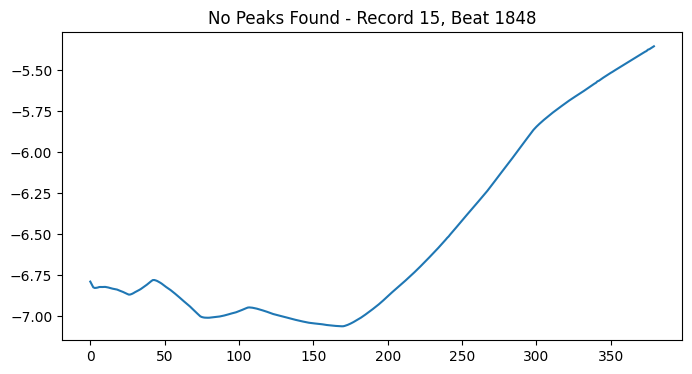

Record: 15, Beat Length: 380
Number of Peaks Found: 0


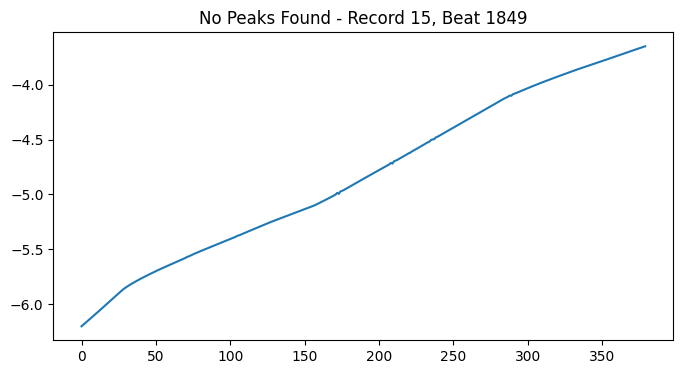

Record: 15, Beat Length: 380
Number of Peaks Found: 0


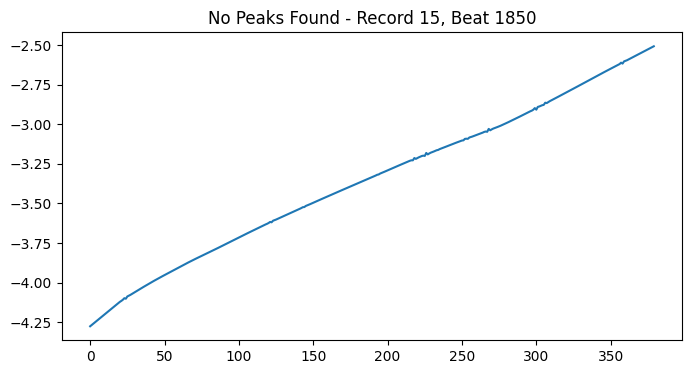

Record: 15, Beat Length: 380
Number of Peaks Found: 0


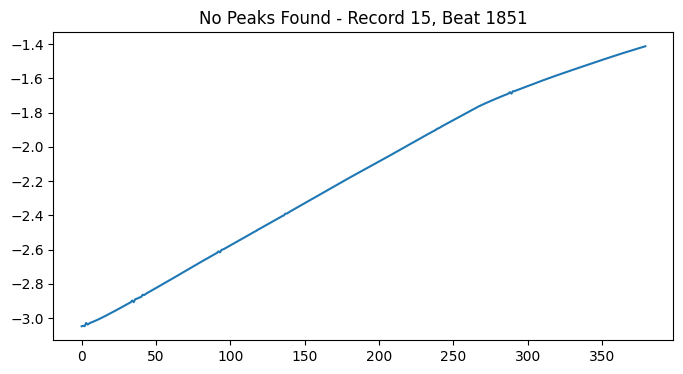

Record: 15, Beat Length: 380
Number of Peaks Found: 0


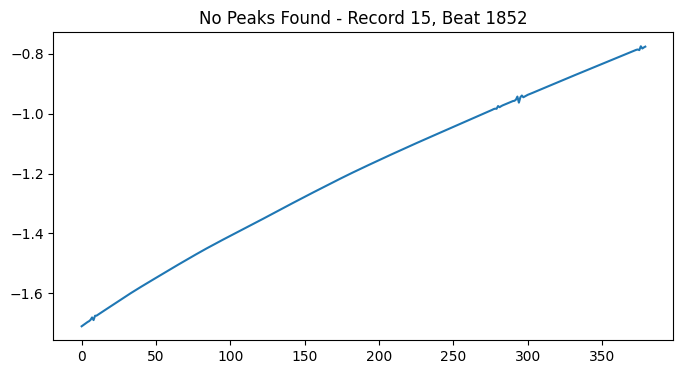

Record: 15, Beat Length: 380
Number of Peaks Found: 0


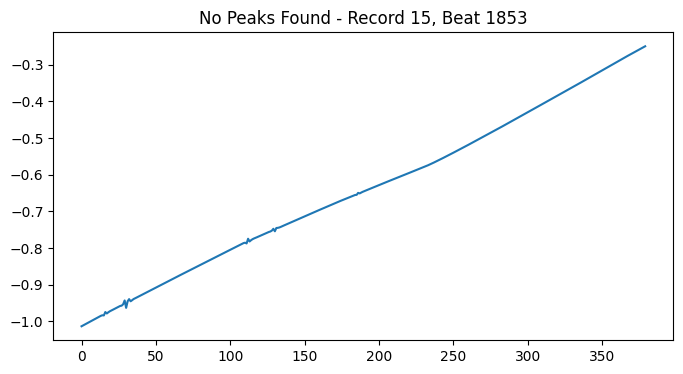

Record: 15, Beat Length: 380
Number of Peaks Found: 0


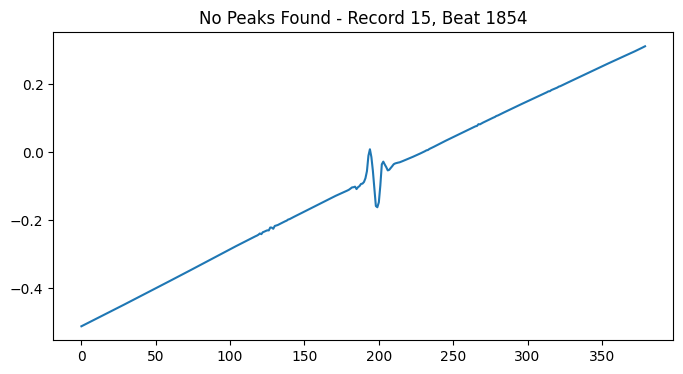

Streaming output truncated to the last 5000 lines.
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Number of Peaks Found: 6
Record: 18, Beat Length: 380
Number of Peaks Found: 3
Record: 18, Beat Length: 380
Number of Peaks Found: 5
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Number of Peaks Found: 6
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Number of Peaks Found: 5
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Number of Peaks Found: 5
Record: 18, Beat Length: 380
Number of Peaks Found: 5
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Number of Peaks Found: 3
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Number of Peaks Found: 4
Record: 18, Beat Length: 380
Nu

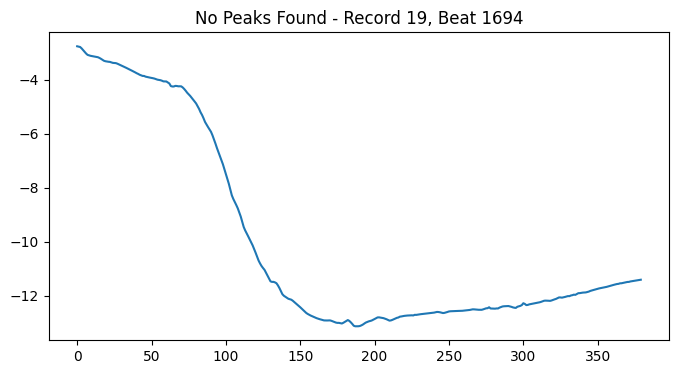

Streaming output truncated to the last 5000 lines.
Record: 27, Beat Length: 380
Number of Peaks Found: 3
Record: 27, Beat Length: 380
Number of Peaks Found: 4
Record: 27, Beat Length: 380
Number of Peaks Found: 5
Record: 27, Beat Length: 380
Number of Peaks Found: 5
Record: 27, Beat Length: 380
Number of Peaks Found: 4
Record: 27, Beat Length: 380
Number of Peaks Found: 3
Record: 27, Beat Length: 380
Number of Peaks Found: 3
Record: 27, Beat Length: 380
Number of Peaks Found: 5
Record: 27, Beat Length: 380
Number of Peaks Found: 4
Record: 27, Beat Length: 380
Number of Peaks Found: 3
Record: 27, Beat Length: 380
Number of Peaks Found: 4
Record: 27, Beat Length: 380
Number of Peaks Found: 6
Record: 27, Beat Length: 380
Number of Peaks Found: 5
Record: 27, Beat Length: 380
Number of Peaks Found: 5
Record: 27, Beat Length: 380
Number of Peaks Found: 6
Record: 27, Beat Length: 380
Number of Peaks Found: 6
Record: 27, Beat Length: 380
Number of Peaks Found: 5
Record: 27, Beat Length: 380
Nu

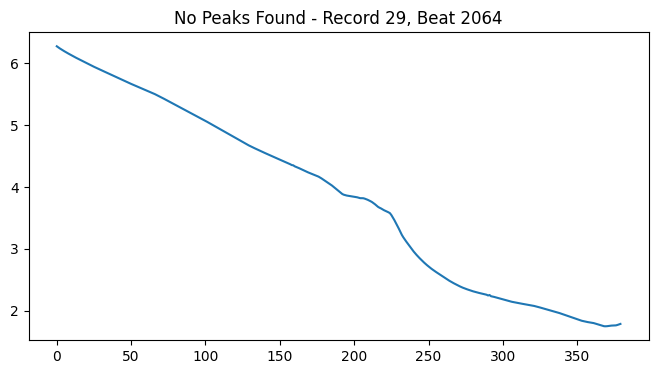

Record: 29, Beat Length: 380
Number of Peaks Found: 1
Record: 29, Beat Length: 380
Number of Peaks Found: 2
Record: 29, Beat Length: 380
Number of Peaks Found: 3
Record: 29, Beat Length: 380
Number of Peaks Found: 4
Record: 29, Beat Length: 380
Number of Peaks Found: 5
Record: 29, Beat Length: 380
Number of Peaks Found: 4
Record: 29, Beat Length: 380
Number of Peaks Found: 3
Record: 29, Beat Length: 380
Number of Peaks Found: 4
Record: 29, Beat Length: 380
Number of Peaks Found: 5
Record: 29, Beat Length: 380
Number of Peaks Found: 3
Record: 29, Beat Length: 380
Number of Peaks Found: 5
Record: 29, Beat Length: 380
Number of Peaks Found: 6
Record: 29, Beat Length: 380
Number of Peaks Found: 4
Record: 29, Beat Length: 380
Number of Peaks Found: 7
Record: 29, Beat Length: 380
Number of Peaks Found: 9
Record: 29, Beat Length: 380
Number of Peaks Found: 7
Record: 29, Beat Length: 380
Number of Peaks Found: 10
Record: 29, Beat Length: 380
Number of Peaks Found: 11
Record: 29, Beat Length: 3

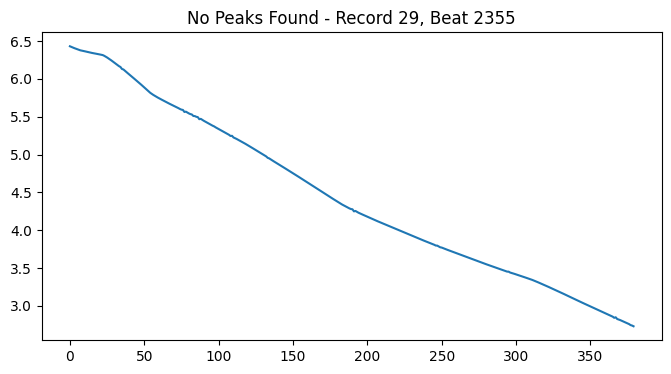

Record: 29, Beat Length: 380
Number of Peaks Found: 0


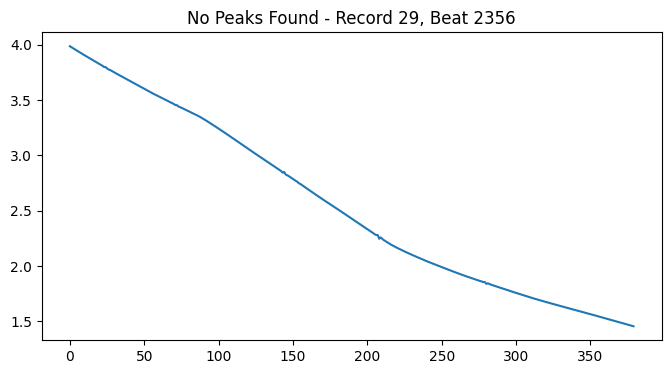

Record: 29, Beat Length: 380
Number of Peaks Found: 0


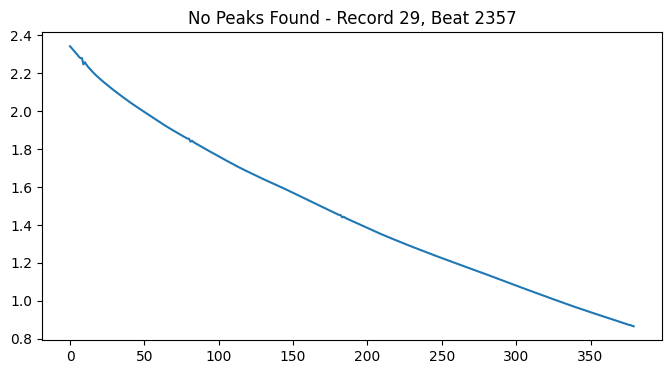

Record: 29, Beat Length: 380
Number of Peaks Found: 0


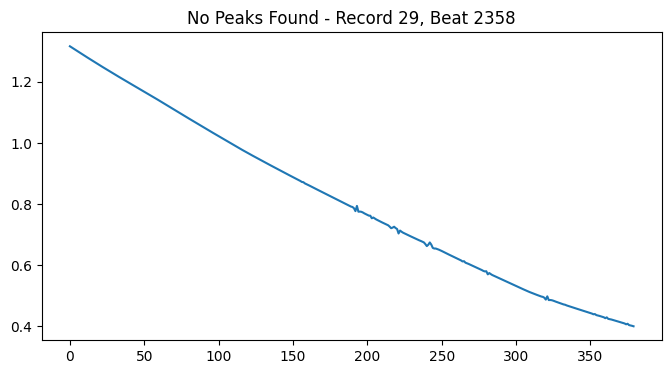

Record: 29, Beat Length: 380
Number of Peaks Found: 0


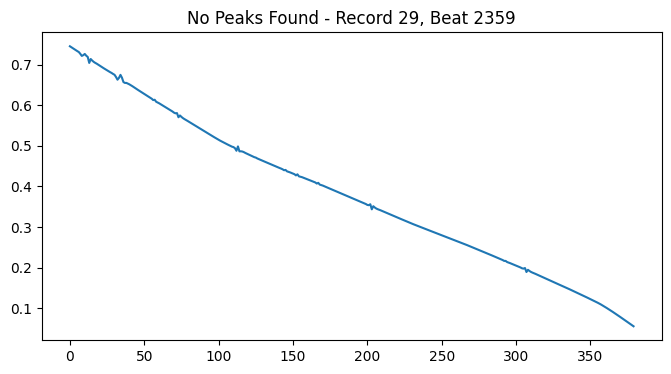

Record: 29, Beat Length: 380
Number of Peaks Found: 0


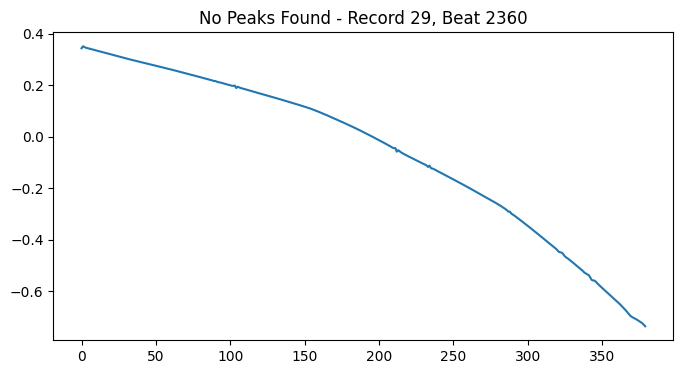

Streaming output truncated to the last 5000 lines.
Record: 41, Beat Length: 380
Number of Peaks Found: 1
Record: 41, Beat Length: 380
Number of Peaks Found: 5
Record: 41, Beat Length: 380
Number of Peaks Found: 5
Record: 41, Beat Length: 380
Number of Peaks Found: 4
Record: 41, Beat Length: 380
Number of Peaks Found: 5
Record: 41, Beat Length: 380
Number of Peaks Found: 6
Record: 41, Beat Length: 380
Number of Peaks Found: 4
Record: 41, Beat Length: 380
Number of Peaks Found: 3
Record: 41, Beat Length: 380
Number of Peaks Found: 3
Record: 41, Beat Length: 380
Number of Peaks Found: 4
Record: 41, Beat Length: 380
Number of Peaks Found: 3
Record: 41, Beat Length: 380
Number of Peaks Found: 2
Record: 41, Beat Length: 380
Number of Peaks Found: 4
Record: 41, Beat Length: 380
Number of Peaks Found: 4
Record: 41, Beat Length: 380
Number of Peaks Found: 1
Record: 41, Beat Length: 380
Number of Peaks Found: 4
Record: 41, Beat Length: 380
Number of Peaks Found: 4
Record: 41, Beat Length: 380
Nu

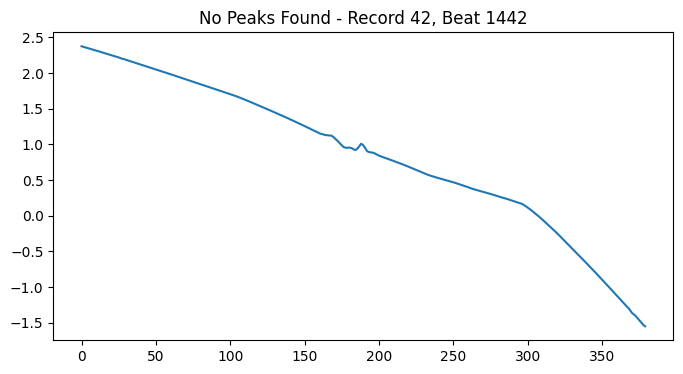

Streaming output truncated to the last 5000 lines.
Record: 47, Beat Length: 380
Number of Peaks Found: 4
Record: 47, Beat Length: 380
Number of Peaks Found: 2
Record: 47, Beat Length: 380
Number of Peaks Found: 2
Record: 47, Beat Length: 380
Number of Peaks Found: 2
Record: 47, Beat Length: 380
Number of Peaks Found: 2
Record: 47, Beat Length: 380
Number of Peaks Found: 4
Record: 47, Beat Length: 380
Number of Peaks Found: 4
Record: 47, Beat Length: 380
Number of Peaks Found: 3
Record: 47, Beat Length: 380
Number of Peaks Found: 2
Record: 47, Beat Length: 380
Number of Peaks Found: 2
Record: 47, Beat Length: 380
Number of Peaks Found: 5
Record: 47, Beat Length: 380
Number of Peaks Found: 2
Record: 47, Beat Length: 380
Number of Peaks Found: 3
Record: 47, Beat Length: 380
Number of Peaks Found: 4
Record: 47, Beat Length: 380
Number of Peaks Found: 3
Record: 47, Beat Length: 380
Number of Peaks Found: 3
Record: 47, Beat Length: 380
Number of Peaks Found: 3
Record: 47, Beat Length: 380
Nu

In [12]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV files
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.figure(figsize=(12, 6))
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()

    signals = denoise_fun(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.figure(figsize=(12, 6))
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()

    signals = stats.zscore(signals)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.figure(figsize=(12, 6))
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()

    # Read annotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()
        beat = list()


        for d in range(1, len(data)):
            splitted = data[d].split(' ')
            splitted = list(filter(None, splitted))

            # Create an iterator from the list
            splitted_iter = iter(splitted)

            next(splitted_iter) # Time... Clipping
            pos = int(next(splitted_iter)) # Sample ID
            arrhythmia_type = next(splitted_iter) # Type
            # pos = int(next(splitted)) # Sample ID
            # arrhythmia_type = next(splitted) # Type
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]

                    # --- DEBUGGING ---
                    print(f"Record: {r}, Beat Length: {len(beat)}")
                    peaks, _ = find_peaks(beat, prominence=0.2)
                    print(f"Number of Peaks Found: {len(peaks)}")

                    if len(peaks) == 0:
                        plt.figure(figsize=(8, 4))
                        plt.plot(beat)
                        plt.title(f"No Peaks Found - Record {r}, Beat {d}")
                        plt.show()
                        continue

                    time_features = extract_time_domain_features(beat)
                    freq_features = extract_frequency_domain_features(beat)

                    # Combine features (you can experiment with different combinations)
                    all_features = time_features + freq_features

                    X.append(all_features)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

# Convert to NumPy arrays for easier handling
X = np.array(X)
y = np.array(y)

print(np.shape(X))

In [16]:
X

array([[1.77451089e+01, 1.90000000e+02, 3.46377945e-01, ...,
        3.54472563e+01, 6.66666667e+00, 1.84879389e+01],
       [1.80000000e+01, 1.90000000e+02, 2.58778125e-01, ...,
        4.78844741e+01, 0.00000000e+00, 2.41239165e+01],
       [1.70000000e+01, 1.90000000e+02, 1.97769472e-01, ...,
        3.98950427e+01, 6.66666667e+00, 2.36105269e+01],
       ...,
       [1.40000000e+01, 1.90000000e+02, 1.92501056e-01, ...,
        3.72042300e+01, 0.00000000e+00, 1.56463003e+01],
       [0.00000000e+00, 1.90000000e+02, 5.78138048e-02, ...,
        3.46249199e+01, 0.00000000e+00, 1.58935959e+01],
       [5.35412613e+00, 1.90000000e+02, 1.76581111e-01, ...,
        3.62674287e+01, 0.00000000e+00, 1.57952418e+01]])

In [20]:
y

array([0, 0, 0, ..., 0, 0, 0])

# **EXPLORATORY DATA ANALYTICS**

In [21]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

8
18.487939    1
34.775249    1
19.337529    1
39.929534    1
36.376369    1
            ..
8.787876     1
17.926354    1
12.148821    1
21.484462    1
15.795242    1
Name: count, Length: 92483, dtype: int64


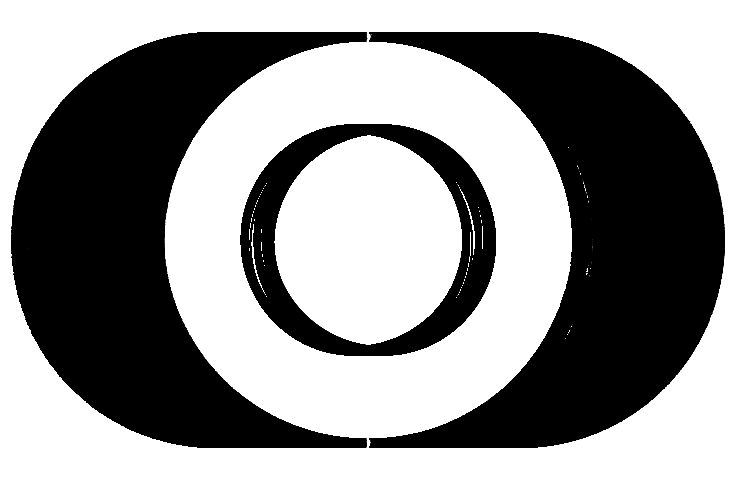

In [24]:
def create_class_distribution_pie_chart(data, class_column_index, custom_colors=None):
  """
  Creates a pie chart visualizing the class distribution in a DataFrame.

  Args:
    data: The input DataFrame.
    class_column_index: The index of the column containing class labels.
    custom_colors: (Optional) A list of colors to use for the pie slices.
                   If None, default colors will be used.
  """

  class_counts = data.iloc[:, class_column_index].value_counts()

  # Get unique class labels from your data
  labels = list(class_counts.index)

  plt.figure(figsize=(10, 6))  # Adjust figure size as needed

  # Create a white circle in the center for a donut chart effect
  my_circle = plt.Circle((0, 0), 0.7, color='white')

  plt.pie(class_counts,
          labels=labels,  # Use the dynamically generated labels
          colors=custom_colors,
          autopct='%1.1f%%',
          wedgeprops={'linewidth': 3, 'edgecolor': 'white'})  # Add white border to slices

  p = plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

# Example usage with custom colors:
my_colors = ['#F08080', '#BA55D3', '#9ACD32', '#6495ED', '#FFA07A']
create_class_distribution_pie_chart(X_train_df, X_train_df.shape[1] - 1, my_colors)

In [25]:
X_train_df.isnull().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [26]:
X_train_df.describe()

,0,1,2,3,4,5,6,7,8
count,92483.000000,92483.0,92483.000000,92483.000000,92483.000000,92483.000000,92483.000000,92483.000000,92483.000000
mean,27.455348,190.0,0.725437,-0.002992,0.816505,2.795389,15.728121,1.970257,19.324178
std,14.776745,0.0,1.400355,0.426739,0.268287,1.980946,11.678282,2.315132,5.511545
min,0.000000,190.0,-9.868822,-10.248780,0.093427,-4.390368,-1.830120,0.000000,2.049394
25%,18.170684,190.0,-0.010321,-0.165381,0.673124,1.311214,5.154882,0.000000,15.720431
50%,27.299267,190.0,0.283114,-0.008734,0.788494,3.012036,13.460784,0.952381,18.794288
75%,35.953674,190.0,0.802351,0.154121,0.915453,4.407995,24.315972,2.857143,21.887100
max,87.500000,190.0,10.716584,10.658631,7.118986,7.155449,56.020600,25.714286,54.581263


In [27]:
X_train_df

,0,1,2,3,4,5,6,7,8
0,17.745109,190.0,0.346378,0.006494,0.853581,5.481632,35.447256,6.666667,18.487939
1,18.000000,190.0,0.258778,-0.135722,0.793075,6.405716,47.884474,0.000000,24.123917
2,17.000000,190.0,0.197769,-0.119587,0.747242,5.488919,39.895043,6.666667,23.610527
3,16.000000,190.0,0.244189,-0.097651,0.678485,6.024610,46.003746,16.190476,23.861176
4,0.000000,190.0,0.199608,-0.102644,0.732865,5.866087,43.016742,14.285714,22.779546
...,...,...,...,...,...,...,...,...,...
92478,18.821265,190.0,0.202352,-0.286388,0.754137,6.002022,38.241151,0.000000,16.646869
92479,23.000000,190.0,-0.246419,-0.328806,0.759512,5.702960,34.852792,0.000000,15.277616
92480,14.000000,190.0,0.192501,-0.355533,0.696741,5.900658,37.204230,0.000000,15.646300
92481,0.000000,190.0,0.057814,-0.272596,0.750086,5.720907,34.624920,0.000000,15.893596


from matplotlib import pyplot as plt
X_train_df[0].plot(kind='hist', bins=20, title=0)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_train_df[2].plot(kind='hist', bins=20, title=2)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_train_df[3].plot(kind='hist', bins=20, title=3)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_train_df[4].plot(kind='hist', bins=20, title=4)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_train_df.plot(kind='scatter', x=0, y=2, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_train_df.plot(kind='scatter', x=2, y=3, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_train_df.plot(kind='scatter', x=3, y=4, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
X_train_df.plot(kind='scatter', x=4, y=5, s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[1]
  ys = series[0]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_train_df.sort_values(1, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(1)
_ = plt.ylabel(0)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[1]
  ys = series[2]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_train_df.sort_values(1, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(1)
_ = plt.ylabel(2)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[1]
  ys = series[3]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_train_df.sort_values(1, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(1)
_ = plt.ylabel(3)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series[1]
  ys = series[4]
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = X_train_df.sort_values(1, ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel(1)
_ = plt.ylabel(4)

from matplotlib import pyplot as plt
X_train_df[0].plot(kind='line', figsize=(8, 4), title=0)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
X_train_df[2].plot(kind='line', figsize=(8, 4), title=2)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
X_train_df[3].plot(kind='line', figsize=(8, 4), title=3)
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
X_train_df[4].plot(kind='line', figsize=(8, 4), title=4)
plt.gca().spines[['top', 'right']].set_visible(False)

In [28]:
y

array([0, 0, 0, ..., 0, 0, 0])

**PCA DIMENSIONALITY REDUCTION TECHNIQUE**

In [29]:
# 1. Standardize the Data (Important for PCA)
scaler = StandardScaler()
balanced_records_scaled = scaler.fit_transform(X_train_df)

# 2. Apply PCA
pca = PCA(n_components=0.95)  # Keep components explaining 95% of variance
balanced_records_reduced = pca.fit_transform(balanced_records_scaled)

# 3. Create a New DataFrame (Optional)
balanced_records_reduced_df = pd.DataFrame(balanced_records_reduced)

# Print shapes and explained variance
print("Reduced DataFrame shape:", balanced_records_reduced_df.shape)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Total Explained Variance:", sum(pca.explained_variance_ratio_))

Reduced DataFrame shape: (92483, 7)
Explained Variance Ratio: [0.2720936  0.16433466 0.14032614 0.12673008 0.12585841 0.08708663
 0.07021737]
Total Explained Variance: 0.9866468802852448


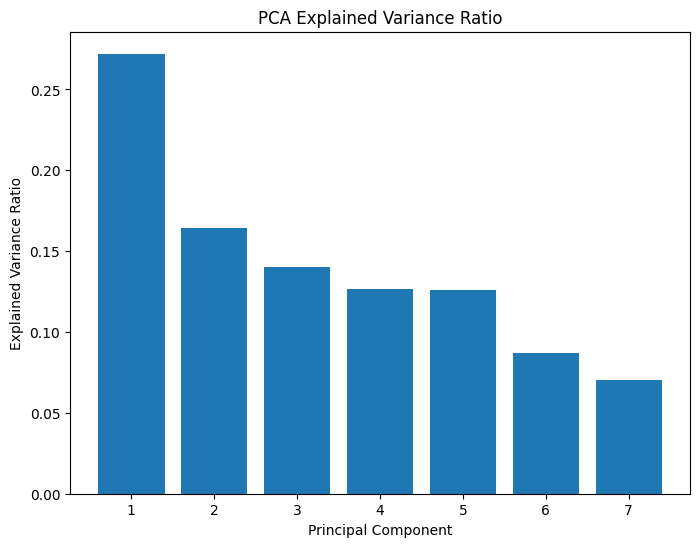

In [30]:
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

In [31]:
balanced_records_reduced_df

,0,1,2,3,4,5,6
0,2.163550,1.504834,0.599255,0.636628,-1.118409,0.418310,-0.403788
1,2.849170,0.396467,-0.110060,-0.449350,-0.012758,-2.047408,-0.143356
2,2.556893,1.214392,1.341643,0.175046,-1.253420,0.003622,-0.208640
3,3.595577,2.984624,3.462341,1.183268,-2.853593,2.244685,-0.194191
4,3.263233,2.806347,2.541065,0.591890,-3.379639,1.739780,-0.531547
...,...,...,...,...,...,...,...
92478,2.393563,-0.006035,-1.116726,0.028219,-0.154173,-1.094903,0.129491
92479,2.241569,-0.376340,-1.179769,0.291429,-0.017809,-0.794693,0.014922
92480,2.416243,-0.115643,-1.343844,-0.153636,-0.453650,-0.935572,0.227317
92481,2.176461,0.065025,-1.604630,-0.600094,-1.112381,-1.029967,-0.252697


In [32]:
balanced_records_reduced_df.shape

(92483, 7)

# **Model Building and Evaluation**

**Spliting the Train and Test data**

In [33]:
X_train,X_test,y_train, y_test = train_test_split(balanced_records_reduced_df,y, test_size=0.2)
print("X_train : ", np.shape(X_train))
print("X_test  : ", np.shape(X_test))

X_train :  (73986, 7)
X_test  :  (18497, 7)


**Random Forest Model Developement**

In [60]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

# Train the classifier using extracted features and corresponding labels
rf_classifier.fit(X_train, y_train)

# Predict labels for validation data
y_pred_valid = rf_classifier.predict(X_test)



**Random Forest Model Evaluation**

In [61]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_valid)
f1 = f1_score(y_test, y_pred_valid, average='macro')  # Use 'macro' for multi-class
precision = precision_score(y_test, y_pred_valid, average='macro')
recall = recall_score(y_test, y_pred_valid, average='macro')

# ROC-AUC requires probability scores for multi-class
y_pred_proba = rf_classifier.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 'ovr' for multi-class

# Print metrics
print("Random Forest Classifier Accuracy:", accuracy)
print("Random Forest Classifier F1 Score:", f1)
print("Random Forest Classifier Precision:", precision)
print("Random Forest Classifier Recall:", recall)
print("Random Forest Classifier ROC-AUC:", roc_auc)

Random Forest Classifier Accuracy: 0.9420446558901443
Random Forest Classifier F1 Score: 0.7223572623906654
Random Forest Classifier Precision: 0.8980667831130151
Random Forest Classifier Recall: 0.6629968416183338
Random Forest Classifier ROC-AUC: 0.9411414950238154


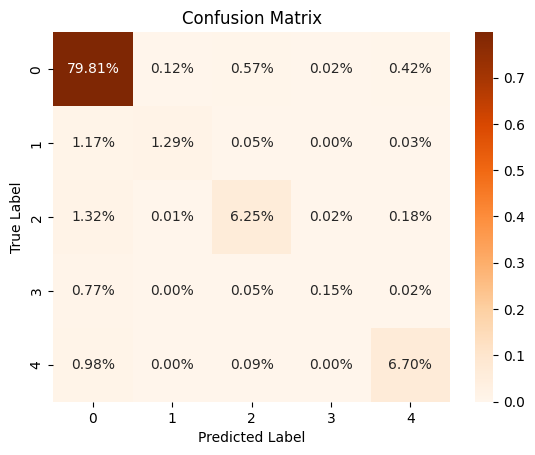

<Figure size 640x480 with 0 Axes>

In [36]:
cm = confusion_matrix(y_test, y_pred_valid)
sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('Confusion_matrice_rf.png')

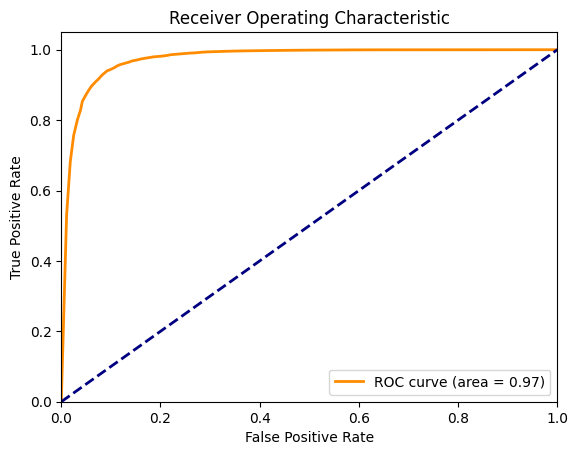

In [37]:
#ROC Curve and AUC
y_prob = rf_classifier.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Decision Tree Classifier Model Development**

In [38]:
# Create the Decision Tree classifier
clf_dt = DecisionTreeClassifier(random_state=42)

# Train the classifier on the normalized training data
clf_dt.fit(X_train, y_train)

# Make predictions on the normalized validation set
y_pred_valid = clf_dt.predict(X_test)


**Decision Tree Classifier Model Evaluation**



In [39]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_valid)
f1 = f1_score(y_test, y_pred_valid, average='macro')  # Use 'macro' for multi-class
precision = precision_score(y_test, y_pred_valid, average='macro')
recall = recall_score(y_test, y_pred_valid, average='macro')

# ROC-AUC requires probability scores for multi-class
y_pred_proba = rf_classifier.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 'ovr' for multi-class

# Print metrics
print("Decision Tree Classifier Accuracy:", accuracy)
print("Decision Tree Classifier F1 Score:", f1)
print("Decision Tree Classifier Precision:", precision)
print("Decision Tree Classifier Recall:", recall)
print("Decision Tree Classifier ROC-AUC:", roc_auc)

Decision Tree Classifier Accuracy: 0.9014975401416446
Decision Tree Classifier F1 Score: 0.6364124507040618
Decision Tree Classifier Precision: 0.6372456198804801
Decision Tree Classifier Recall: 0.6361609438885689
Decision Tree Classifier ROC-AUC: 0.9411414950238154


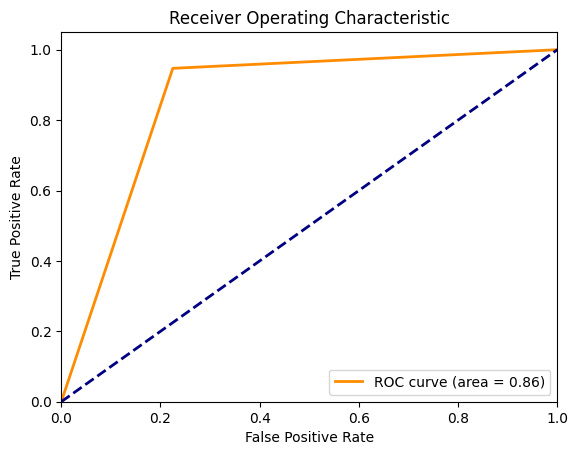

In [40]:
#ROC Curve and AUC

y_prob = clf_dt.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

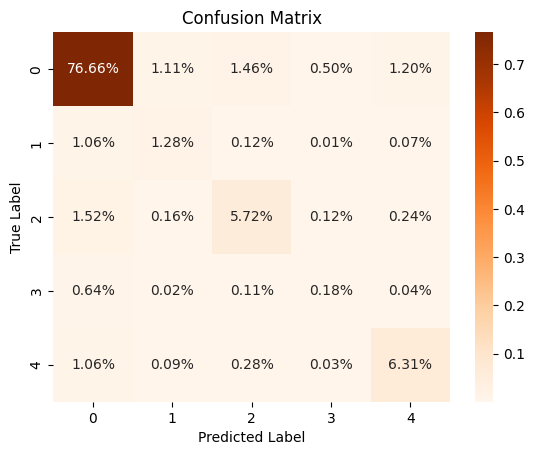

<Figure size 640x480 with 0 Axes>

In [41]:
cm = confusion_matrix(y_test, y_pred_valid)
sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('Confusion_matrice_dc.png')

**LogisticRegression Model Development**

In [42]:
lin_reg=LogisticRegression()
lin_reg.fit(X_train, y_train)
y_pred_valid = lin_reg.predict(X_test)


**LogisticRegression Model Evaluation**

In [43]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_valid)
f1 = f1_score(y_test, y_pred_valid, average='macro')  # Use 'macro' for multi-class
precision = precision_score(y_test, y_pred_valid, average='macro')
recall = recall_score(y_test, y_pred_valid, average='macro')

# ROC-AUC requires probability scores for multi-class
y_pred_proba = rf_classifier.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # 'ovr' for multi-class

# Print metrics
print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression F1 Score:", f1)
print("Logistic Regression Precision:", precision)
print("Logistic Regression Recall:", recall)
print("Logistic Regression ROC-AUC:", roc_auc)

Logistic Regression Accuracy: 0.8573282153862789
Logistic Regression F1 Score: 0.3916430018612477
Logistic Regression Precision: 0.44825141608668406
Logistic Regression Recall: 0.3714019549188844
Logistic Regression ROC-AUC: 0.9411414950238154


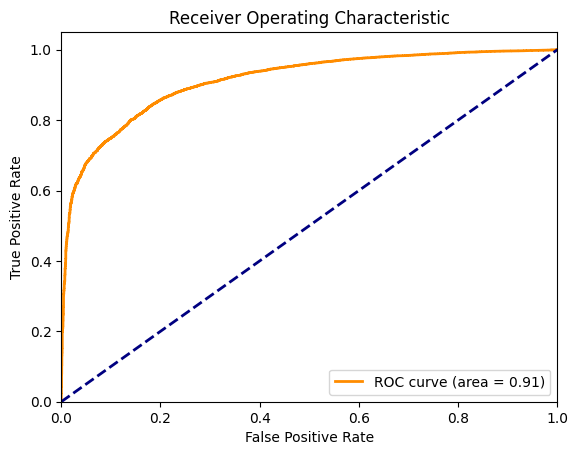

In [44]:
#ROC Curve and AUC
y_prob = lin_reg.predict_proba(X_test)[:, 0]
fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

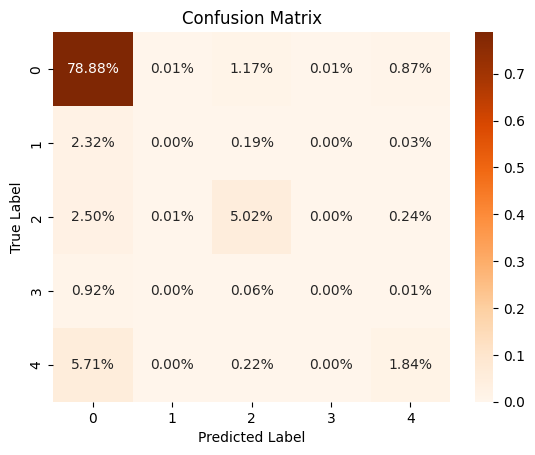

<Figure size 640x480 with 0 Axes>

In [45]:
cm = confusion_matrix(y_test, y_pred_valid)
sns.heatmap(cm/np.sum(cm), annot=True,fmt='.2%', cmap='Oranges')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('Confusion_matrice_lg.png')

# **SAVE MODEL**

In [66]:
rf_classifier.fit(X_train, y_train)
filename = 'ecg_pred.pkl'
joblib.dump(rf_classifier, filename)

['ecg_pred.pkl']

In [67]:
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

0.9420446558901443
